# PyDDA tutorial

![PyDDA logo](https://openradarscience.org/PyDDA/_images/logo.png)


PyDDA is an open source Python package for retrieving winds using Multiple Doppler analyses. It uses the 3D variational technique for retrieving winds from multiple Doppler radars. It uses Py-ART Grid Objects as inputs. Therefore, preprocessed and gridded data are needed for PyDDA to run.

## 3D variational technique
PyDDA uses a 3D variational technique to retrieve the 3D wind field. We will leave students that are interested in more information about these technqiues two references to read at the end of this notebook. A basic introduction to 3D variational analysis is given here.

PyDDA minimizes a cost function $J$ that corresponds to various penalties including:

$J_{m} = \nabla \cdot V$ which corresponds to the mass continuity equation.

$J_{o} = $ RMSE between radar winds and analysis winds.

$J_{b} = $ RMSE between sounding winds and analysis winds.

$J_{s} = \nabla^2 V$ which corresponds to the smoothness of wind field to eliminate high-frequency noise that can result from numerical instability.

The cost function to be minimized is a weighted sum of the various cost functions in PyDDA and are represented in Equation (1):

<p style="text-align: center;">$J = c_{m}J_{m} + c_{o}J_{o} + c_{b}J_{b} + c_{s}J_{s} + ...$ (1)</p>

### References


## Imports

Let's import the necessary libraries. For now, we'll need PyART, glob, matplotlib, and PyDDA.

In [1]:
import glob

import pyart
import matplotlib.pyplot as plt
import pydda
import warnings
import numpy as np
import pandas as pd
import fsspec
import cartopy.crs as ccrs

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Welcome to PyDDA 2.0.0
If you are using PyDDA in your publications, please cite:
Jackson et al. (2020) Journal of Open Research Science
Detecting Jax...
Jax engine enabled!
Detecting TensorFlow...
TensorFlow detected. Checking for tensorflow-probability...
TensorFlow-probability detected. TensorFlow engine enabled!


## Case study

We will examine the same case study over Italy that has been used for this entire short course. For this case in May 2024, we had weak convective cells in the region of 

For this case, we had coverage of the storm from two radars, a MeteoSwiss C-band radar near Monte Lema, CH and an X-band radar from ARPA Lombardia located about 50 km away in Milano, IT.

### C-band Radar

We need to load and preprocess the C-band radar data first. In order to do so, we first need to load the MeteoSwiss C-band radar file.

In [2]:
# Set the URL and path for the cloud
URL = "https://js2.jetstream-cloud.org:8001/"
path = f"pythia/radar/erad2024"


fs = fsspec.filesystem("s3", anon=True, client_kwargs=dict(endpoint_url=URL))

fs.glob(f"{path}/*")

files = fs.glob("pythia/radar/erad2024/dda_data/*")
local_files = [
    fsspec.open_local(
        f"simplecache::{URL}{i}", s3={"anon": True}, filecache={"cache_storage": "."}
    )
    for i in files
]

radar = pyart.io.read(local_files[1])

In [3]:
radar.info()

altitude:
	data: <ndarray of type: float32 and shape: (1,)>
	long_name: Altitude
	units: meters
	standard_name: Altitude
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (7200,)>
	long_name: azimuth_angle_from_true_north
	units: degrees
	standard_name: beam_azimuth_angle
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (7200,)>
	long_name: elevation_angle_from_horizontal_plane
	units: degrees
	standard_name: beam_elevation_angle
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float64 and shape: (7200, 492)>
		_FillValue: -9999.0
		long_name: Horizontal Reflectivity
		units: dBZ
		standard_name: horizontal_reflectivity
		coordinates: elevation azimuth range
	signal_to_noise_ratio:
		data: <ndarray of type: float64 and shape: (7200, 492)>


### Dealiasing

The next step is to dealias the radar data. We will follow the steps that were shown eariler in this course to dealias the radar data. Dealiasing is covered in detail in the [Radar Cookbook](https://projectpythia.org/radar-cookbook/notebooks/foundations/pyart-corrections.html).

In [4]:
nyquist = radar.instrument_parameters["nyquist_velocity"]["data"][0]
vel_dealias = pyart.correct.dealias_region_based(
    radar,
    vel_field="velocity",
    nyquist_vel=nyquist,
    centered=True,
)
radar.add_field("corrected_velocity", vel_dealias, replace_existing=True)

Plot the data to make sure dealiasing succeeded.

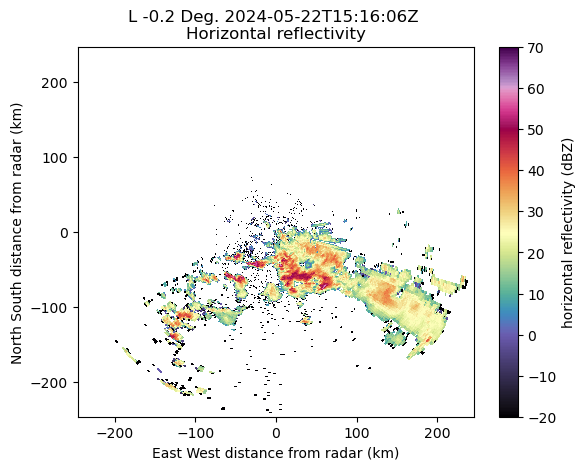

In [5]:
display = pyart.graph.RadarDisplay(radar)
display.plot("reflectivity", vmin=-20, vmax=70, cmap="pyart_ChaseSpectral", sweep=0)

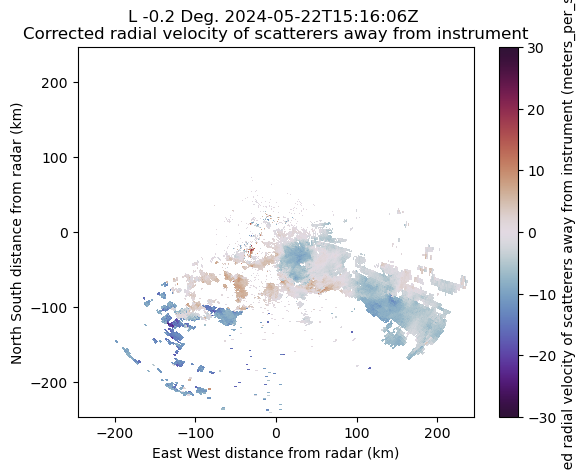

In [6]:
display = pyart.graph.RadarDisplay(radar)
display.plot("corrected_velocity", vmin=-30, vmax=30, cmap="twilight_shifted", sweep=0)

Some regions did not dealias correctly, like in the region around (-100 km, -100 km) where gate-to-gate shear exceeds the Nyquist interval in the absence of . The region-based algorithm is very sensitive to speckles that are present in the above image. Let's despeckle the above radar data to remove some artifacts.

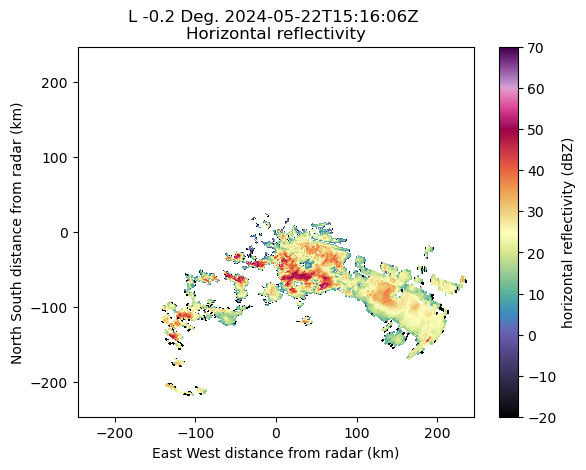

In [7]:
gatefilter = pyart.filters.GateFilter(radar)
gatefilter.exclude_above("spectrum_width", 7)
# gatefilter.exclude_below('cross_correlation_ratio', 0.8)
gatefilter = pyart.correct.despeckle_field(
    radar, "reflectivity", gatefilter=gatefilter, size=36
)
display = pyart.graph.RadarDisplay(radar)
display.plot(
    "reflectivity",
    vmin=-20,
    vmax=70,
    gatefilter=gatefilter,
    cmap="pyart_ChaseSpectral",
    sweep=0,
)

Let's also tweak the settings of the region based dealiasing. Currently, the dealiasing will attempt to dealias regions that are separated by 100 masked gates in the radial. We will disable this feature by setting `skip_between_rays` to 0 so that all dealiasing across filtered gates along the azimuth is disabled.

In [8]:
nyquist = radar.instrument_parameters["nyquist_velocity"]["data"][0]
vel_dealias = pyart.correct.dealias_region_based(
    radar,
    vel_field="velocity",
    nyquist_vel=nyquist,
    gatefilter=gatefilter,
    centered=True,
    skip_between_rays=0,
)
radar.add_field("corrected_velocity", vel_dealias, replace_existing=True)

Let's plot all of the sweeps to make sure dealiasing worked correctly. 
A good indicator of checking this is to check if there are discontinuities in the radial velocities between sweeps on the order of the Nyquist velocity. If there are such discontinuties, further tweaking of the parameters or grounding the retrieval to a sounding may be needed. Using these parameters, the above example radar data is properly dealiased.

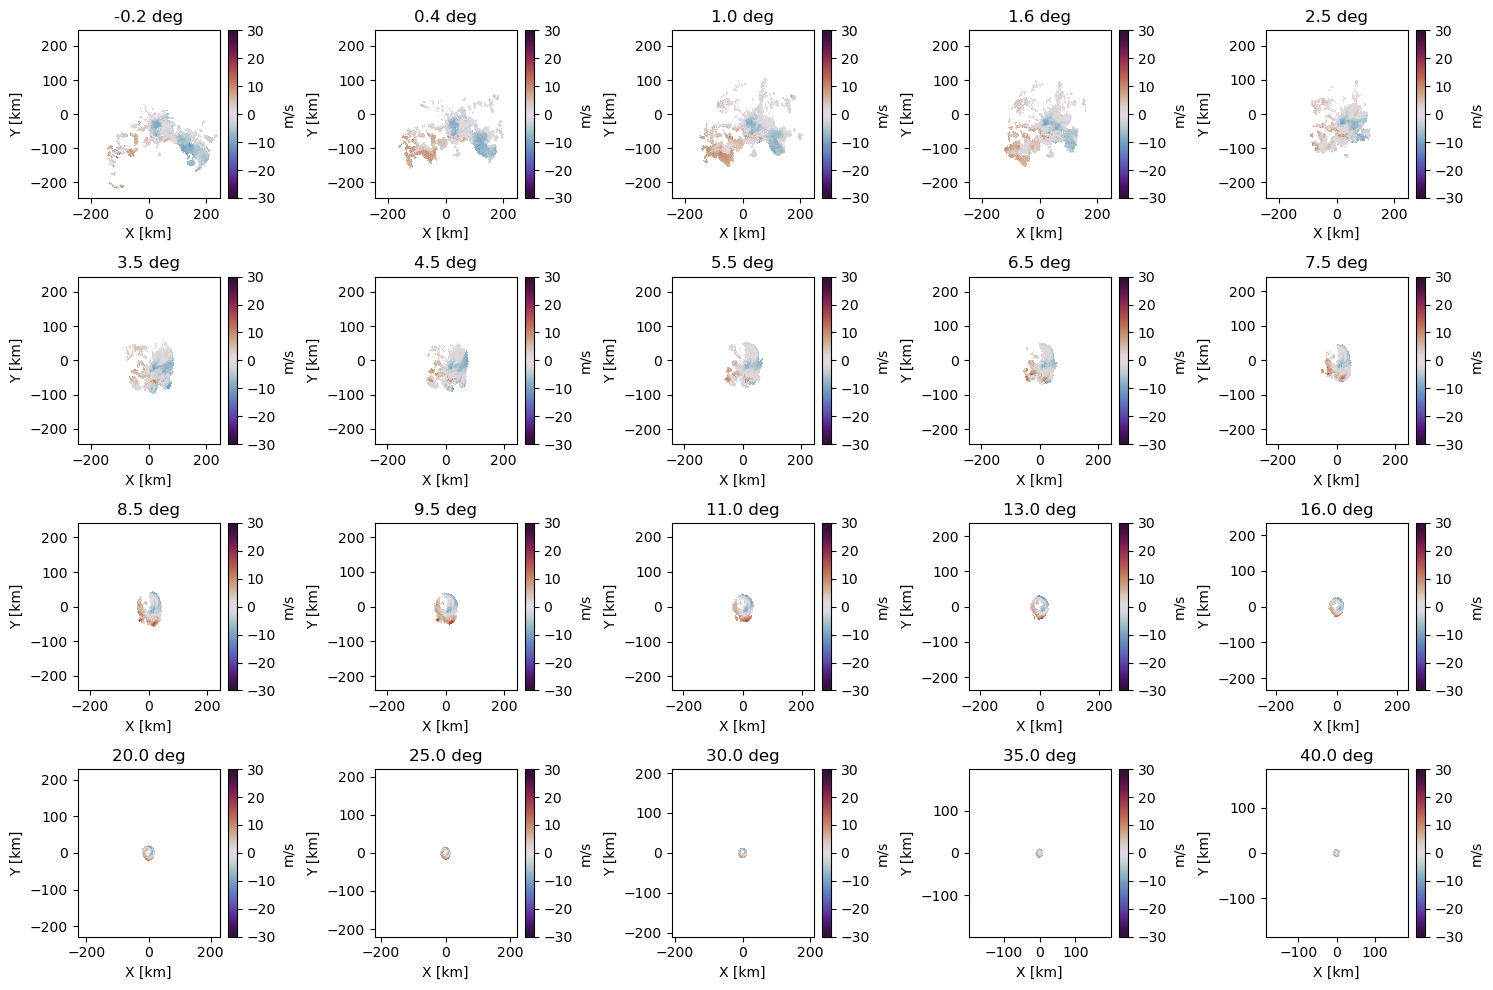

In [9]:
display = pyart.graph.RadarDisplay(radar)
fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for i in range(radar.nsweeps):
    display.plot(
        "corrected_velocity",
        vmin=-30,
        vmax=30,
        cmap="twilight_shifted",
        sweep=i,
        colorbar_label="m/s",
        ax=ax[int(i / 5), i % 5],
    )
    ax[int(i / 5), i % 5].set_title("%2.1f deg" % radar.fixed_angle["data"][i])
    ax[int(i / 5), i % 5].set_xlabel("X [km]")
    ax[int(i / 5), i % 5].set_ylabel("Y [km]")
fig.tight_layout()

In [10]:
pyart.io.write_cfradial("MonteLema.20240522.151606_dealiased.nc", radar)

## Gridding

PyDDA requires data to be gridded to Cartesian coordinates in order to retrieve the 3D wind fields. Therefore, we will use Py-ART's *grid_from_radars* function in order to do the gridding. You usually want to have a grid resolution such that your features of interest are covered by four grid points. In this case, we're at 1 km horizontal and 0.5 km vertical resolution. For more information on gridding with Py-ART, see the [Radar Cookbook](https://projectpythia.org/radar-cookbook/notebooks/foundations/pyart-gridding.html).

In [11]:
grid_limits = ((0.0, 15000.0), (-100_000.0, 100_000.0), (-100_000.0, 100_000.0))
grid_shape = (31, 201, 201)
radar.fields["corrected_velocity"]["data"] = np.ma.masked_where(
    gatefilter.gate_excluded, radar.fields["corrected_velocity"]["data"]
)
radar.fields["reflectivity"]["data"] = np.ma.masked_where(
    gatefilter.gate_excluded, radar.fields["reflectivity"]["data"]
)

cband_grid = pyart.map.grid_from_radars(
    [radar], grid_limits=grid_limits, grid_shape=grid_shape
)
cband_ds = cband_grid.to_xarray()
cband_ds

<xarray.Dataset> Size: 106MB
Dimensions:                              (time: 1, z: 31, y: 201, x: 201)
Coordinates:
  * time                                 (time) object 8B 2024-05-22 15:16:06...
  * z                                    (z) float64 248B 0.0 500.0 ... 1.5e+04
    lat                                  (y, x) float64 323kB 45.13 ... 46.93
    lon                                  (y, x) float64 323kB 7.558 ... 10.15
  * y                                    (y) float64 2kB -1e+05 ... 1e+05
  * x                                    (x) float64 2kB -1e+05 ... 1e+05
Data variables:
    spectrum_width                       (time, z, y, x) float64 10MB 2.603 ....
    uncorrected_differential_phase       (time, z, y, x) float64 10MB 2.025 ....
    corrected_velocity                   (time, z, y, x) float64 10MB 3.374 ....
    reflectivity                         (time, z, y, x) float64 10MB 23.59 ....
    velocity                             (time, z, y, x) float64 10MB 3.374 ....
    reflectivity_hh_clut                 (time, z, y, x) float64 10MB 23.53 ....
    reflectivity_vv                      (time, z, y, x) float64 10MB 23.51 ....
    differential_reflectivity            (time, z, y, x) float64 10MB 0.02067...
    uncorrected_cross_correlation_ratio  (time, z, y, x) float64 10MB 0.8806 ...
    signal_to_noise_ratio                (time, z, y, x) float64 10MB 13.93 ....
    ROI                                  (time, z, y, x) float32 5MB 2.469e+0...
Attributes: (12/16)
    nradar:           1
    radar_name:       {'long_name': 'Name of radar used to make the grid', 'd...
    Conventions:      CF/Radial instrument_parameters
    version:          1.3
    title:            
    institution:      
    ...               ...
    field_names:      reflectivity, signal_to_noise_ratio, reflectivity_vv, d...
    history:          
    volume_number:    0
    platform_type:    fixed
    instrument_type:  radar
    primary_axis:     axis_z

Let's make sure the grid looks good!

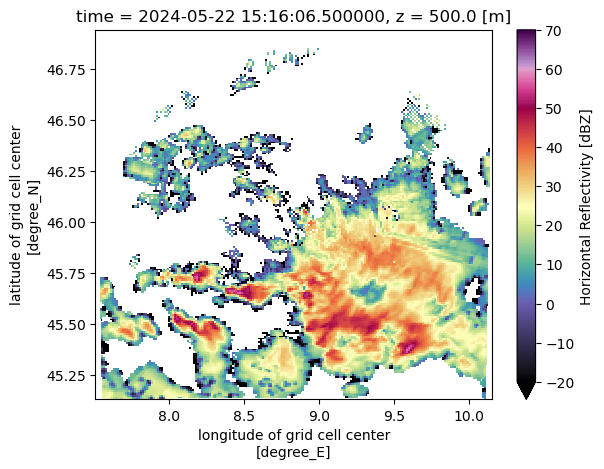

In [12]:
cband_ds.isel(z=1).reflectivity.plot(
    x="lon", y="lat", vmin=-20, vmax=70, cmap="pyart_ChaseSpectral"
)

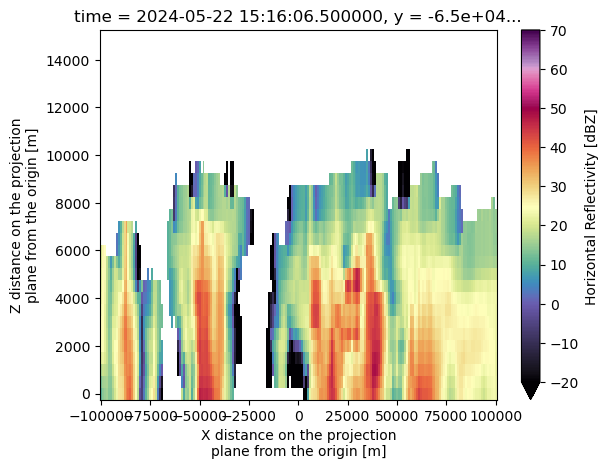

In [13]:
cband_ds.isel(y=35).reflectivity.plot(
    x="x", y="z", vmin=-20, vmax=70, cmap="pyart_ChaseSpectral"
)

### X-band Data

Next, we need to load the X-band radar data from the archive.

In [14]:
radar_xband = pyart.io.read(local_files[0])

Read a single file, the one closes to the UAH volume scan used before

In [15]:
radar.info()

altitude:
	data: <ndarray of type: float32 and shape: (1,)>
	long_name: Altitude
	units: meters
	standard_name: Altitude
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (7200,)>
	long_name: azimuth_angle_from_true_north
	units: degrees
	standard_name: beam_azimuth_angle
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (7200,)>
	long_name: elevation_angle_from_horizontal_plane
	units: degrees
	standard_name: beam_elevation_angle
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	reflectivity:
		data: <ndarray of type: float64 and shape: (7200, 492)>
		_FillValue: -9999.0
		long_name: Horizontal Reflectivity
		units: dBZ
		standard_name: horizontal_reflectivity
		coordinates: elevation azimuth range
	signal_to_noise_ratio:
		data: <ndarray of type: float64 and shape: (7200, 492)>


Visualize the data to make sure we have the correct scan.

(-100.0, 100.0)

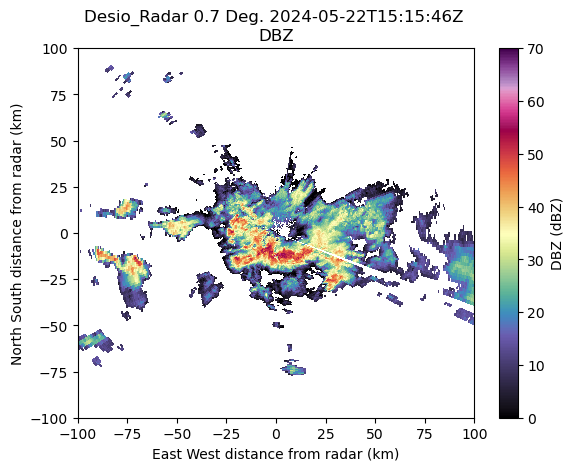

In [16]:
display = pyart.graph.RadarDisplay(radar_xband)
display.plot("DBZ", vmin=0, vmax=70, cmap="pyart_ChaseSpectral", sweep=0)
plt.ylim(-100, 100)
plt.xlim(-100, 100)

The X-band radar data also need to be dealiased. We will still need to filter out the noise in the above radar data.

In [17]:
# Use the C-band radar lat/lon as the center for the grid

gatefilter = pyart.filters.GateFilter(radar_xband)
gatefilter.exclude_above("WIDTH", 7)
gatefilter.exclude_below("RHOHV", 0.8)
gatefilter = pyart.correct.despeckle_field(
    radar_xband, "DBZ", gatefilter=gatefilter, size=100
)
vel_dealias = pyart.correct.dealias_region_based(
    radar_xband,
    vel_field="VEL",
    nyquist_vel=nyquist,
    centered=True,
    skip_between_rays=0,
    skip_along_ray=0,
    interval_splits=3,
)
radar_xband.add_field("corrected_velocity", vel_dealias, replace_existing=True)

Let's view the sweeps to make sure that dealiasing is working correctly.

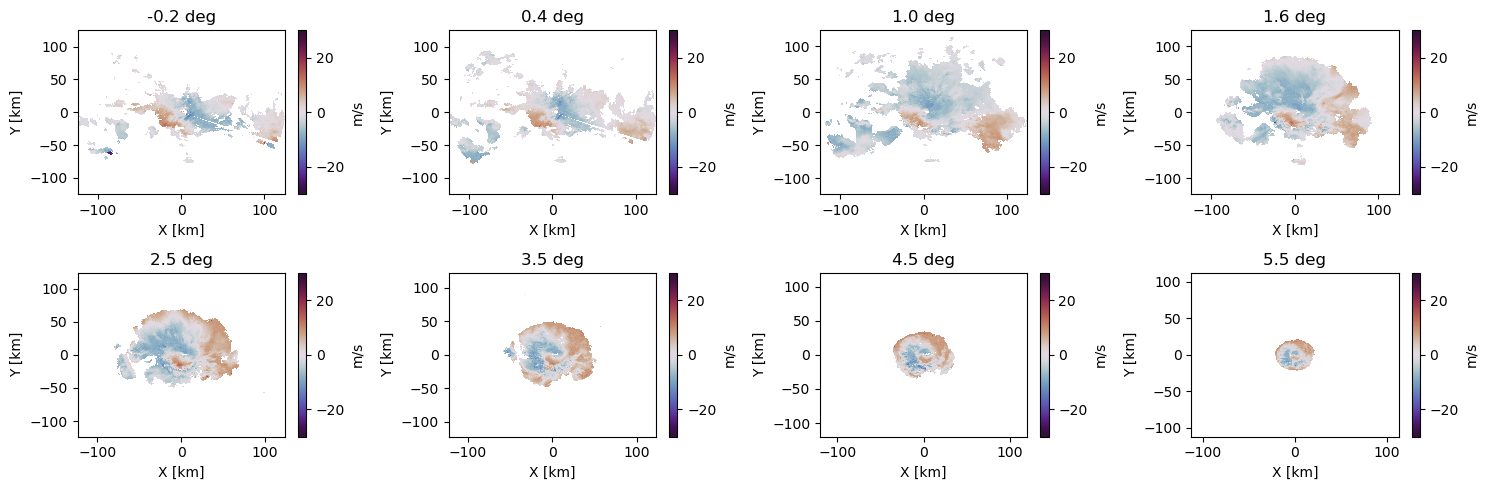

In [18]:
display = pyart.graph.RadarDisplay(radar_xband)
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
for i in range(radar_xband.nsweeps):
    display.plot(
        "corrected_velocity",
        vmin=-30,
        vmax=30,
        cmap="twilight_shifted",
        sweep=i,
        colorbar_label="m/s",
        ax=ax[int(i / 4), i % 4],
    )
    ax[int(i / 4), i % 4].set_title("%2.1f deg" % radar.fixed_angle["data"][i])
    ax[int(i / 4), i % 4].set_xlabel("X [km]")
    ax[int(i / 4), i % 4].set_ylabel("Y [km]")
fig.tight_layout()

In [19]:
pyart.io.write_cfradial("ARPA_Lombardia.20240522.151546_dealiased.nc", radar_xband)

In [20]:
grid_lat = radar.latitude["data"][0]
grid_lon = radar.longitude["data"][0]
xband_grid = pyart.map.grid_from_radars(
    [radar_xband],
    grid_limits=grid_limits,
    grid_shape=grid_shape,
    grid_origin=(grid_lat, grid_lon),
)

# Convert to xarray and remove the time dimension
xband_ds = xband_grid.to_xarray().squeeze()

## Visualize the grids

Let's see what our output data looks like!

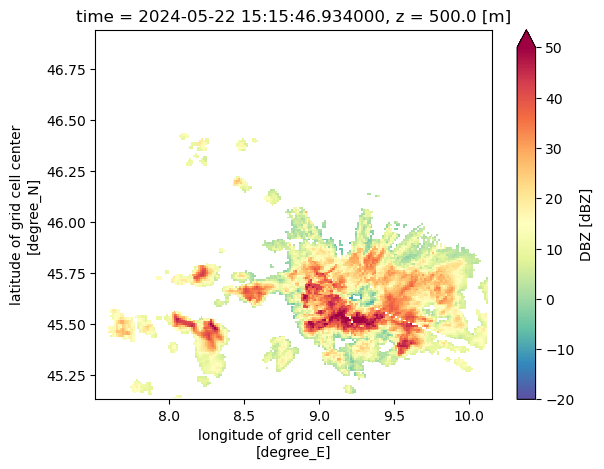

In [21]:
xband_ds.DBZ.isel(z=1).plot(x="lon", y="lat", cmap="Spectral_r", vmin=-20, vmax=50)

Velocities look good!

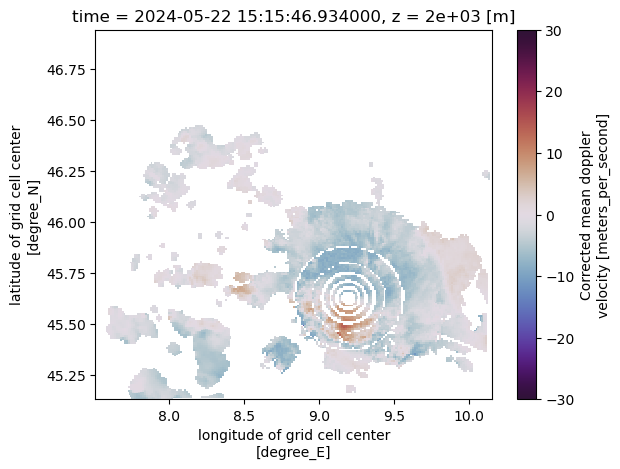

In [22]:
xband_ds.corrected_velocity.isel(z=4).plot(
    x="lon", y="lat", cmap="twilight_shifted", vmin=-30, vmax=30
)

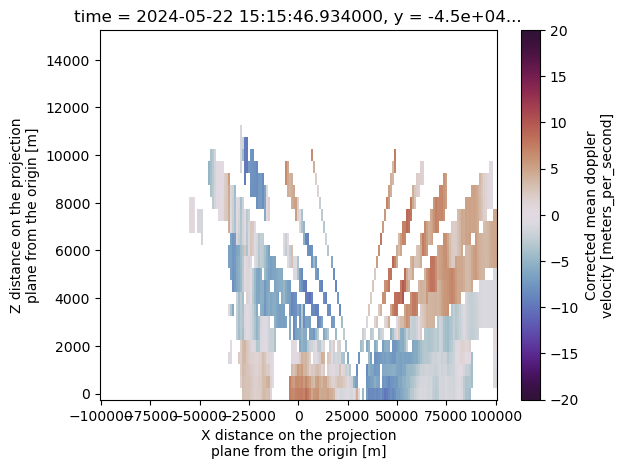

In [23]:
xband_ds.corrected_velocity.isel(y=55).plot(
    x="x", y="z", cmap="twilight_shifted", vmin=-20, vmax=20
)

## PyDDA initialization

The 3DVAR wind retrieval first requires an initial guess at the wind field in order to start the cost function minimization process. PyDDA has support for using WRF and sounding data as an initial guess of the wind field as well as constant wind fields. 

| Initalization functions in **pydda.initialization** module: | Functionality         |
|-------------------------------------------------------------|-----------------------|
| make_constant_wind_field(Grid[, wind, vel_field]) | This function makes a constant wind field given a wind vector |
| make_wind_field_from_profile(Grid, profile) | This function makes a 3D wind field from a sounding. |
| make_background_from_wrf(Grid, file_path, ...) | This function makes an initalization field based off of the u and w from a WRF run.
| make_initialization_from_era_interim(Grid[, ...]) | This function will read ERA Interim in NetCDF format and add it to the Py-ART grid specified by Grid. |

For this example, using a zero initialization field is sufficient to create an accurate representation of the wind field. Depending on your radar set up, you may need to adjust the input initial wind field to avoid artifacts at the edges of the multi-Doppler lobes.

In [24]:
cband_ds = pydda.io.read_from_pyart_grid(cband_grid)
xband_ds = pydda.io.read_from_pyart_grid(xband_grid)
cband_ds = pydda.initialization.make_constant_wind_field(
    cband_ds, (0.0, 0.0, 0.0), "velocity"
)
xband_ds["reflectivity"] = xband_ds["DBZ"]

## PyDDA wind retrieval

The core wind retrieval function in PyDDA is done using **retrieval.get_dd_wind_field**. It has many potential keyword inputs that the user can enter. In this example, we are specifying:

| Input to **pydda.initialization** module: | Meaning | Value              |
|-------------------------------------------|---------|--------------------|
| Grids | The input grids to analyze. | [uah_grid, nexrad_grid] |
| u_init| Initial guess of *u* field. | u_init |
| v_init| Initial guess of *u* field. | v_init |
| w_init| Initial guess of *u* field. | w_init |
| Co | Weight for cost function related to radar observations | 1.0 |
| Cm | Weight of cost function related to mass continuity equation | 256.0|
| Cx | Weight of cost function for smoothess in the *x*-direction| 1e-3|
| Cy | Weight of cost function for smoothess in the *y*-direction| 1e-3|
| Cz | Weight of cost function for smoothess in the *z*-direction| 1e-3|
| Cb | Weight of cost function for sounding (background) constraint| 0 |
| frz| The freezing level in meters. This is to tell PyDDA where to use ice particle fall speeds in the wind retrieval verus liquid. | 5000. |
| filter_window | The window to apply the low pass filter on | 5 |
| mask_outside_opt | Mask all winds outside the Dual Doppler lobes | True
| vel_name| The name of the velocity field in the radar data | 'corrected_velocity' |
| wind_tol | Stop optimization when the change in wind speeds between iterations is less than this value |
| engine | PyDDA supports three backends for optimization: SciPy, JAX, and TensorFlow. | "scipy"

In [25]:
grids, params = pydda.retrieval.get_dd_wind_field(
    [cband_ds, xband_ds],
    Co=1,
    Cm=1024.0,
    Cx=1e-2,
    Cy=1e-2,
    Cz=1e-2,
    frz=5000.0,
    mask_outside_opt=True,
    upper_bc=1,
    vel_name="corrected_velocity",
    wind_tol=0.5,
    engine="scipy",
)

False


Calculating weights for radars 0 and 1
Calculating weights for radars 1 and 0


Calculating weights for models...
Starting solver 
rmsVR = 4.581783784636946
Total points: 230030
The max of w_init is 0.0


Total number of model points: 0


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
      0|225018.1796|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000


The gradient of the cost functions is 4.950675247614054


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     10|  34.4083| 392.7000|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  16.9523


Max change in w: 16.085


The gradient of the cost functions is 0.6383715029246938


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     20|   5.5491| 153.1899|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  13.4433


Max change in w: 8.973


The gradient of the cost functions is 0.6723123436679119


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     30|   7.8224|  73.2793|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  14.9393


Max change in w: 6.432


The gradient of the cost functions is 0.582234285230258


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     40|   7.3156|  57.5159|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  27.5207


Max change in w: 6.491


The gradient of the cost functions is 0.67846610972528


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     50|   0.7408|  59.7204|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  32.4783


The gradient of the cost functions is 0.30557291330146774


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     60|   0.8089|  59.5485|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  32.1450


The gradient of the cost functions is 0.30631472916262437


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     70|   0.6816|  59.6884|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  33.0122


The gradient of the cost functions is 0.30220215717698357


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     80|   0.6993|  59.6325|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  32.8112


The gradient of the cost functions is 0.2917681362090366


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
     90|   0.6757|  59.6542|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  33.1916


The gradient of the cost functions is 0.2786782822470347


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    100|   0.6440|  59.6514|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  33.7041


The gradient of the cost functions is 0.2747334654695774


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    110|   0.6382|  59.6543|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  33.9057


The gradient of the cost functions is 1.0853226344610831


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    120|   0.7693|  59.9989|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.4743


Max change in w: 2.157


The gradient of the cost functions is 0.2642855661530291


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    130|   0.6523|  59.5959|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  35.5306


The gradient of the cost functions is 0.2774927128972392


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    140|   0.6649|  59.5624|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  36.3377


The gradient of the cost functions is 0.25866632663912736


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    150|   0.6552|  59.5546|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  36.1585


The gradient of the cost functions is 0.26001276377032473


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    160|   0.6707|  59.5210|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  36.9809


The gradient of the cost functions is 0.2565228871631343


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    170|   0.6690|  59.5196|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.0096


The gradient of the cost functions is 0.256205445180571


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    180|   0.6720|  59.5080|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.3294


The gradient of the cost functions is 0.25450229363720805


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    190|   0.6737|  59.5032|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.8427


The gradient of the cost functions is 0.25435811988533746


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    200|   0.6732|  59.4985|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  37.9252


The gradient of the cost functions is 0.2528037367461622


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    210|   0.6724|  59.4972|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  38.4874


The gradient of the cost functions is 2.04331424012824


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    220|   0.8126|  60.4458|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  42.4441


The gradient of the cost functions is 0.2505531691485409


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    230|   0.6688|  59.4925|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  38.4192


Max change in w: 1.818


The gradient of the cost functions is 0.2507347447809678


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    240|  19.5743| 141.9802|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  89.3783


The gradient of the cost functions is 0.24758103808464288


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    250|   0.6621|  59.4905|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  38.8797


The gradient of the cost functions is 0.24739519570110888


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    260|   0.6613|  59.4911|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  38.9386


The gradient of the cost functions is 0.24751217301828826


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    270|   0.6592|  59.4892|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  39.1910


The gradient of the cost functions is 4.291183664026434


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    280|   1.2372|  60.5478|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.6677


The gradient of the cost functions is 0.24638003909051479


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    290|   0.6547|  59.4918|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  39.4391


The gradient of the cost functions is 8.167839990431528


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    300|   1.9076|  60.1367|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.3397


The gradient of the cost functions is 0.4170924416185285


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    310|   0.5864|  60.6746|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  44.1338


The gradient of the cost functions is 0.24767287768719704


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    320|   0.6517|  59.4861|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  39.8488


The gradient of the cost functions is 0.24318754831199724


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    330|   0.6012|  59.3620|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  39.8844


Max change in w: 1.631


The gradient of the cost functions is 0.4176164198347478


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    340|   2.4095|  56.1453|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  42.3272


The gradient of the cost functions is 0.4478134154295641


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    350|   2.4223|  56.1240|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  42.2716


The gradient of the cost functions is 0.29808338367150805


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    360|   1.1264|  56.0815|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  42.4743


The gradient of the cost functions is 0.2967212994946185


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    370|   0.6689|  56.1071|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.2161


The gradient of the cost functions is 0.2957556197546136


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    380|   0.6716|  56.1042|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.1960


The gradient of the cost functions is 0.2962155183804333


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    390|   0.6717|  56.1040|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.1947


The gradient of the cost functions is 0.20295191276306826


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    400|   0.4706|  56.1542|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.4186


The gradient of the cost functions is 0.20142559345196445


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    410|   0.4704|  56.1540|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.4177


Max change in w: 2.186


The gradient of the cost functions is 0.269276801222094


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    420|   0.4185|  56.1840|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.5425


The gradient of the cost functions is 0.16413083971733644


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    430|   0.4238|  56.1677|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.4769


The gradient of the cost functions is 0.1634871368702149


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    440|   0.4236|  56.1683|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.4792


The gradient of the cost functions is 0.1641308436351384


Nfeval | Jvel    | Jmass   | Jsmooth |   Jbg   | Jvort   | Jmodel  | Jpoint  | Max w  
    450|   0.4238|  56.1677|   0.0000|   0.0000|   0.0000|   0.0000|   0.0000|  43.4769


Applying low pass filter to wind field...
Done! Time = 362.6


## Visualize the results

Let's visualize the results. There are two ways in which this data can be visualized. One way is by using PyDDA's visualization routines. You can also use xarray to visualize the output grids.

In [26]:
ds = grids[0]
ds

<xarray.Dataset> Size: 216MB
Dimensions:                              (time: 1, z: 31, y: 201, x: 201,
                                          nradar: 1)
Coordinates:
  * time                                 (time) object 8B 2024-05-22 15:16:06...
  * z                                    (z) float64 248B 0.0 500.0 ... 1.5e+04
    lat                                  (y, x) float64 323kB 45.13 ... 46.93
    lon                                  (y, x) float64 323kB 7.558 ... 10.15
  * y                                    (y) float64 2kB -1e+05 ... 1e+05
  * x                                    (x) float64 2kB -1e+05 ... 1e+05
Dimensions without coordinates: nradar
Data variables: (12/29)
    spectrum_width                       (time, z, y, x) float64 10MB 2.603 ....
    uncorrected_differential_phase       (time, z, y, x) float64 10MB 2.025 ....
    corrected_velocity                   (time, z, y, x) float64 10MB 3.374 ....
    reflectivity                         (time, z, y, x) float64 10MB 23.59 ....
    velocity                             (time, z, y, x) float64 10MB 3.374 ....
    reflectivity_hh_clut                 (time, z, y, x) float64 10MB 23.53 ....
    ...                                   ...
    point_latitude                       (z, y, x) float64 10MB 45.13 ... 46.93
    AZ                                   (time, z, y, x) float64 10MB 225.0 ....
    EL                                   (time, z, y, x) float64 10MB -1.136 ...
    u                                    (time, z, y, x) float64 10MB nan ......
    v                                    (time, z, y, x) float64 10MB nan ......
    w                                    (time, z, y, x) float64 10MB nan ......
Attributes: (12/19)
    nradar:           1
    radar_name:       {'long_name': 'Name of radar used to make the grid', 'd...
    Conventions:      CF/Radial instrument_parameters
    version:          1.3
    title:            
    institution:      
    ...               ...
    platform_type:    fixed
    instrument_type:  radar
    primary_axis:     axis_z
    first_grid_name:  spectrum_width
    units:            m
    long_name:        Point altitude

If you are not able to get the above example to run on your laptop, pre-generated grid files are available <a href="https://drive.google.com/drive/folders/1LmfJeiYHcC_NGWuNAW7gAPMUNp7Z4UZq?usp=sharing">here</a>.

(-100000.0, -25000.0)

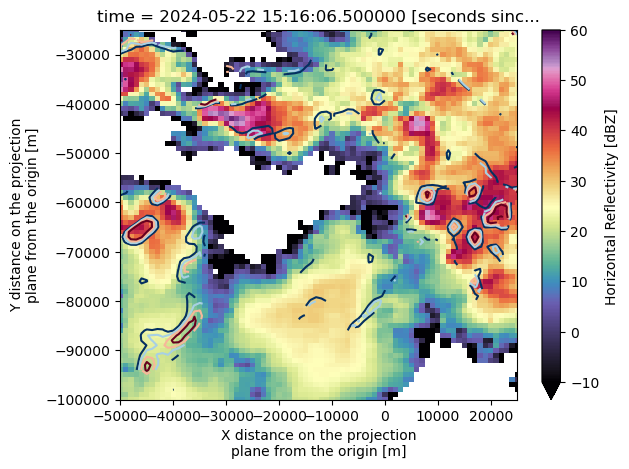

In [27]:
ds.reflectivity.sel(z=2000, method="nearest").plot(
    cmap="pyart_ChaseSpectral", vmin=-10, vmax=60
)
ds.isel(time=0).sel(z=2000, method="nearest").w.plot.contour(
    x="x", y="y", levels=np.arange(1, 5, 1)
)
plt.xlim([-50000, 25000])
plt.ylim([-100000, -25000])

## Saving the grids

We can save the grids using either *xarray*'s or Py-ART's functionality. To save the output grids,  use *pyart.io.write_grid* (PyART) functions. For example:

In [28]:
# Keep these lines if we can't update PyDDA in time for ERAD
grids[0].attrs["radar_name"] = "C-band"
del grids[0]["time"].attrs["units"]
grids[1].attrs["radar_name"] = "X-band"
del grids[1]["time"].attrs["units"]

grids[0].to_netcdf("output_grid_Cband.nc")
grids[1].to_netcdf("output_grid_Xband.nc")

In order to load the grids again, we can just use PyART's *pyart.io.read_grid* procedure.

In [29]:
# For live demos, load these since retrieval takes about 7 minutes
grids = [
    pydda.io.read_grid("output_grid_Cband.nc"),
    pydda.io.read_grid("output_grid_Xband.nc"),
]

## PyDDA visualization routines
PyDDA's visualization routines support the native PyART grids that are output by PyDDA. These routines have an advantage over xarray's plotting routines for adjusting your barb and quiver size by specifying their using parameters that are in scales of kilometers. This makes it easier to plot barb and quiver plots compared to using xarray's functionality. 

For example, the documentation for *pydda.vis.plot_horiz_xsection_quiver* is given below.

In [30]:
?pydda.vis.plot_horiz_xsection_quiver

PyDDA has the following visualization routines for your sets of grids:

| Procedure | Description |
|-----------|-------------|
| plot_horiz_xsection_barbs(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using barbs.
| plot_xz_xsection_barbs(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the X-Z plane using barbs.
| plot_yz_xsection_barbs(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the Y-Z plane using barbs.
| plot_horiz_xsection_barbs_map(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA onto a geographical map using barbs.
| plot_horiz_xsection_streamlines(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using streamlines.
| plot_xz_xsection_streamlines(Grids[, ax, ...])| Cross section of winds from wind fields generated by PyDDA in the X-Z plane using streamlines.
| plot_yz_xsection_streamlines(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the Y-Z plane using streamlines.
| plot_horiz_xsection_streamlines_map(Grids[, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using streamlines.
| plot_horiz_xsection_quiver(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using quivers.  
| plot_xz_xsection_quiver(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the X-Z plane using quivers.
| plot_yz_xsection_quiver(Grids[, ax, ...]) | Cross section of winds from wind fields generated by PyDDA in the Y-Z plane using quivers.
| plot_horiz_xsection_quiver_map(Grids[, ax, ...]) | Horizontal cross section of winds from wind fields generated by PyDDA using quivers onto a geographical map.

Let's show a quiver plot of this storm!

We have specified the quivers to be 4 km apart and moved the key to the bottom right with the specific length indicating 20 m/s winds. Let's look at the 3 km level.

(-100.0, -25.0)

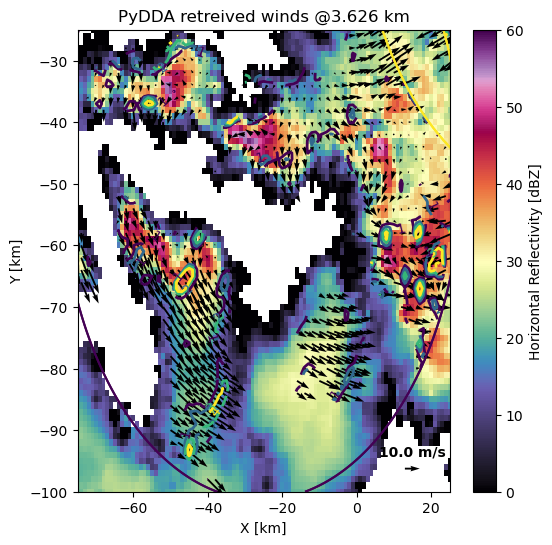

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
pydda.vis.plot_horiz_xsection_quiver(
    grids,
    quiver_spacing_x_km=2.5,
    quiver_spacing_y_km=2.5,
    quiver_width=0.005,
    vmax=60,
    quiverkey_len=10.0,
    w_vel_contours=np.arange(1, 5, 1),
    level=4,
    cmap="pyart_ChaseSpectral",
    ax=ax,
    quiverkey_loc="bottom_right",
)
plt.xlim([-75, 25])
plt.ylim([-100, -25])

We can zoom in and modify the plot using standard matplotlib functions on the axis handle.

It is much easier to see updrafts being placed just to the outside of the strongest precipitation, with potential new growth in the north of the domain with updraft velocities > 7 m/s. The precipitation is downwind of the updraft as we would expect.

Updrafts are right tilted due to the horizontal wind shear. The horizontal wind shear also causes the most intense precipitation to be downshear of the updraft. This therefore shows us that we have a good quality wind retrieval below about 5 km in altitude.

(0.0, 13.0)

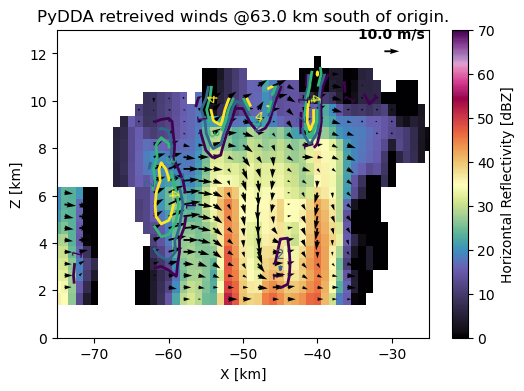

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
pydda.vis.plot_xz_xsection_quiver(
    grids,
    quiver_spacing_x_km=2.0,
    quiver_spacing_z_km=1.0,
    quiver_width=0.005,
    quiverkey_len=10.0,
    w_vel_contours=np.arange(1, 5, 1),
    level=37,
    cmap="pyart_ChaseSpectral",
    ax=ax,
    quiverkey_loc="top_right",
)
ax.set_xlim([-75, -25])
ax.set_ylim([0, 13])

Let's view a horizontal cross section with barbs!

<Axes: title={'center': 'PyDDA retreived winds @4.626 km'}, xlabel='X [km]', ylabel='Y [km]'>

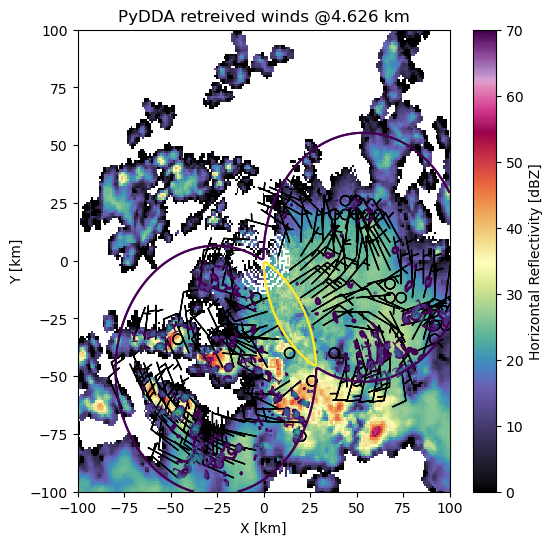

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
pydda.vis.plot_horiz_xsection_barbs(
    grids,
    barb_spacing_x_km=6.0,
    barb_spacing_y_km=6.0,
    w_vel_contours=np.arange(1, 10, 1),
    level=6,
    cmap="pyart_ChaseSpectral",
    ax=ax,
)
# ax.set_xlim([-60, 0])
# ax.set_ylim([0, 70])

In [34]:
cband_ds["time"][0].dt.year.values

array(2024)